# Born to slide: mobile origin licensing factors confer resistance to conflicts with RNA polymerase

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S1I

#### Archives:

#### Additional data:
+ 210804_ORC-bypass-MCM-load_Pos0.xlsx

### Imports

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


### Figure style and output directory

In [2]:
from figure_style import *

In [3]:
set_style_paper()

In [4]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'

### Load dataset & overview

In [5]:
path = '/Volumes/pool-duderstadt/Matthias/Manuscript/Additional_data/Photobleaching_kinetics/'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            files.append(os.path.join(r, file))

In [6]:
labels = 'AF488 LD555 LD655'.split()
df = pd.DataFrame()
for label in labels:
    df_label = pd.DataFrame()
    for i,file in enumerate(filter(lambda file: label in file.split('/')[-1],files)):
        df_temp = pd.read_csv(file, sep=',', header=[0])
        df_temp['survival'] = df_temp['peaks']/df_temp['peaks'].max()
        df_temp.columns = df_temp.columns+'_'+str(i)
        df_temp['label'] =label
        
        df_label = pd.concat([df_label, df_temp],axis=1)
    df = pd.concat([df, df_label],axis=0)
df = df.loc[:,~df.columns.duplicated()]
df['peaks_total'] = df['peaks_0'] + df['peaks_1']

In [7]:
df.reset_index(drop=True, inplace=True)

In [8]:
for row,col in df.iterrows():
    df.loc[row,'survival_mean'] = np.mean([df.loc[row,'survival_0'], df.loc[row,'survival_1']])
    df.loc[row,'survival_std'] = np.std([df.loc[row,'survival_0'], df.loc[row,'survival_1']])


In [9]:
len(df)

1700

In [10]:
df

,peaks_0,slice_0,survival_0,label,peaks_1,slice_1,survival_1,peaks_total,survival_mean,survival_std
0,268.0,1.0,0.974545,AF488,251.0,1.0,0.988189,519.0,0.981367,0.006822
1,268.0,2.0,0.974545,AF488,254.0,2.0,1.000000,522.0,0.987273,0.012727
2,275.0,3.0,1.000000,AF488,230.0,3.0,0.905512,505.0,0.952756,0.047244
3,248.0,4.0,0.901818,AF488,240.0,4.0,0.944882,488.0,0.923350,0.021532
4,245.0,5.0,0.890909,AF488,227.0,5.0,0.893701,472.0,0.892305,0.001396
...,...,...,...,...,...,...,...,...,...,...
1695,13.0,496.0,0.058559,LD655,20.0,496.0,0.104712,33.0,0.081635,0.023077
1696,12.0,497.0,0.054054,LD655,19.0,497.0,0.099476,31.0,0.076765,0.022711
1697,12.0,498.0,0.054054,LD655,18.0,498.0,0.094241,30.0,0.074147,0.020093
1698,11.0,499.0,0.049550,LD655,17.0,499.0,0.089005,28.0,0.069277,0.019728


## Figures

In [11]:
from scipy.optimize import curve_fit

In [12]:
def objective(x,a,b):
    return a*0.5**(x/b)

In [13]:
data = df[df['label']=='LD655']
x = data['slice_0']
y = data['survival_mean']
popt, pcov = curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y0 = %.5f\nt1/2 = %.5f' % (a, b))

y0 = 0.97531
t1/2 = 144.47325


In [14]:
np.sqrt(np.diag(pcov))

array([0.00203812, 0.45801334])

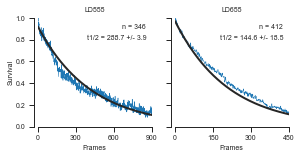

In [15]:
labels = 'LD555 LD655'.split()
fig, axes = plt.subplots(1,len(labels),figsize=(4.5,2), sharey=True)
nobs = df.groupby('label')['peaks_total'].max()

for i,label in enumerate(labels):
    data = df[df['label']==label]
    
    #fit on the mean
    x = data['slice_0']
    y = data['survival_mean']
    popt, _ = curve_fit(objective, x, y)
    a, b = popt

    # get std by fitting both experiments individually
    y = data['survival_0']
    popt, _ = curve_fit(objective, x, y)
    a0, b0 = popt
    y = data['survival_1']
    popt, _ = curve_fit(objective, x, y)
    a1, b1 = popt
    mean = np.mean([b0,b1])
    std = np.std([b0,b1])
    
    # plot input vs output
    axes[i].plot(x, y, lw=.5)
    
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 1)
    # calculate the output for the range
    #y_line = objective(x_line, a, b, c)
    y_line = objective(x_line, a, b)
    # create a line plot for the mapping function
    axes[i].plot(x_line, y_line, '-', color='.15', lw=2)
    axes[i].set_title(label)
    axes[i].set_xlabel('Frames')
    #axes[i].set_ylabel('Survival')
    axes[i].set_ylim([0,1])
    if i ==0:
        axes[i].set_xlim(0,900)
    elif i ==1:
        axes[i].set_xlim(0,450)
    axes[i].text(.95*axes[i].get_xlim()[-1], .95*axes[i].get_ylim()[-1], "n = "+str(int(nobs[label])),
    horizontalalignment='right',verticalalignment='top')
    axes[i].text(.95*axes[i].get_xlim()[-1], .85*axes[i].get_ylim()[-1], f"t1/2 = {np.round(mean,1)} +/- {np.round(std,1)}",
    horizontalalignment='right',verticalalignment='top')

axes[0].set_xticks([0,300,600,900])
axes[1].set_xticks([0,150,300,450])

fig.text(0.04, 0.5, 'Survival', rotation=90, horizontalalignment='center', verticalalignment='center')
    
#fig.tight_layout()
sns.despine(offset=dict(left=4), trim=True)
plt.savefig(dir_out+'S1I_Dyes_photobleaching_kinetics.svg',transparent=True)